# Forward Rendering

This notebook demonstrates how to solve the radiative transfer using SHDOM and render an image.

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis and Amit Aides, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [2]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np

import shdom

In [3]:
""" 
Mie object loads a previously saved mie table.

Rayleigh object initilizes Rayleigh scattering according to a temperature profile.
Temperature profile here is of summer mid-latitude for 0-20km taken from AFGL  
"""

# Mie scattering for water droplets
mie = shdom.Mie()
mie.read_table(file_path='../mie_tables/Water_672nm.scat')

# Rayleigh scattering for air molecules
temperatures = np.array([292.220, 292.040, 291.860, 291.680, 291.500, 291.320, 291.140, 290.960, 290.780, 
                         290.600, 290.420, 290.240, 290.060, 289.880, 289.700, 289.920, 290.140, 290.360, 
                         290.580, 290.800, 291.020, 291.240, 291.460, 291.680, 291.900])
z_grid = shdom.Grid(z=np.linspace(0.0, 20.0, len(temperatures)))
temperature_profile = shdom.GridData(z_grid, temperatures)
air = shdom.Air(wavelength=0.672, temperature_profile=temperature_profile)

Reading mie table from file: ../mie_tables/Water_672nm.scat
Done.


In [4]:
""" 
Load a Large-Eddy-Simulated cloud from a csv file.
Using the mie tables (loaded in the previous cell) the liquid water content and 
effective radii are transformed into the extinction and phase function on a 3D grid.
The lwc/phase are used to initilize a Medium object.
"""
csv_path = '../synthetic_cloud_fields/jpl_les/32x36x25.txt'

lwc, reff = shdom.load_les_from_csv(csv_path)
extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(lwc, reff)
cloud = shdom.Medium(extinction_c, albedo_c, phase_c)

atmosphere = cloud + air

In [5]:
"""
Initilize an RteSolver object and attach the Medium to it. 
This will initialize all of shdom internal structures and grids.

SceneParameters() contains parameters such as surface albedo and solar radiance
NumericalParameters() contains parameters such as number of angular bins and split cell ratio.
All parameters have default values.
"""
scene_params = shdom.SceneParameters()
numerical_params = shdom.NumericalParameters()

rte_solver = shdom.RteSolver(scene_params, numerical_params)
rte_solver.init_medium(atmosphere)
print(rte_solver.info)

Scene Parameters: 
   Wavelength: [0.67 micron]
   Surface: [Lambertian, albedo: 0.05]
   Source: [Solar, flux: 1.0, azimuth: 0.0deg, zenith: 180.0deg]
   Boundary Conditions: [x:open, y:open]

Numerical Parameters: 
   acceleration_flag: True
   adapt_grid_factor: 10
   deltam: True
   cell_to_point_ratio: 1.3
   num_mu_bins: 8
   high_order_radiance: True
   max_total_mb: 100000.0
   solution_accuracy: 0.0001
   spherical_harmonics_accuracy: 0.003
   split_accuracy: 0.1
   num_phi_bins: 16
   num_sh_term_factor: 9



In [6]:
"""
Solve Radiative Transfer for the atmospheric domain using SHDOM solve_rte procedure. 
The outputs are the Source function (J) and Radiance field (I) which are stored in 
the shdom.RteSolver object. These can be subsequently used for rendering of an image.
"""
rte_solver.solve(maxiter=100)

In [7]:
"""
Define a sensor and render an image of the domain. The Orthographic sensor is essentially
parallel rays measuring radiance at a given direction.
"""
sensor = shdom.OrthographicSensor(bounding_box=atmosphere.bounding_box, 
                                  x_resolution=0.02, 
                                  y_resolution=0.02, 
                                  azimuth=0.0, 
                                  zenith=0.0,
                                  altitude='TOA')

image = sensor.render(rte_solver)

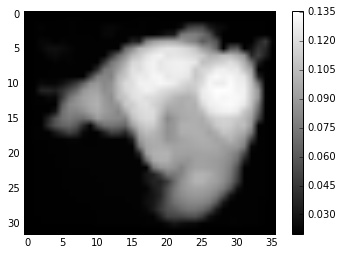

In [8]:
"""
Plot the synthetic image.
"""
%matplotlib inline
plt.imshow(image)
plt.gray()
plt.colorbar()